In [1]:
# Import libraries
import os
import warnings
import pandas as pd
import tqdm
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

# Set pandas options and warnings filters
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

In [2]:
# Load StatsBomb data
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

# La Liga
selected_competitions = competitions[
    (competitions.competition_name == "Premier League")
    & (competitions.season_name == "2015/2016")
]
selected_competitions

print(selected_competitions)

    season_id  competition_id competition_name country_name  \
64         27               2   Premier League      England   

   competition_gender season_name  
64               male   2015/2016  


In [3]:
# Get game data from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}

for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(
        events,
        home_team_id=game.home_team_id,
        xy_fidelity_version=1,
        shot_fidelity_version=1
    )

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

Loading game data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [13:44<00:00,  2.17s/it]


In [4]:
# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

In [5]:
# Compute features and labels
# Import libraries
import socceraction.spadl as spadl
import socceraction.vaep.features as fs
import socceraction.vaep.labels as lab

# Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder, "features.h5")
labels_h5 = os.path.join(datafolder, "labels.h5")

games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

# Compute features
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.result,
    fs.result_onehot,
    fs.goalscore,
    fs.startlocation,
    fs.endlocation,
    fs.movement,
    fs.space_delta,
    fs.startpolar,
    fs.endpolar,
    fs.team,
    fs.time,
    fs.time_delta
]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(features_h5) as featurestore:
    for game in tqdm.tqdm(list(games.itertuples()), desc=f"Generating and storing features in {features_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        gamestates = fs.gamestates(spadl.add_names(actions), 3)
        gamestates = fs.play_left_to_right(gamestates, game.home_team_id)

        X = pd.concat([fn(gamestates) for fn in xfns], axis=1)
        featurestore.put(f"game_{game.game_id}", X, format='table')

# Compute labels
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(labels_h5) as labelstore:
    for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        Y = pd.concat([fn(spadl.add_names(actions)) for fn in yfns], axis=1)
        labelstore.put(f"game_{game.game_id}", Y, format='table')

nb of games: 380


Generating and storing features in ../data-fifa/features.h5: 100%|███████████████████████████████████████████████████████████████████| 380/380 [05:54<00:00,  1.07it/s]
Computing and storing labels in ../data-fifa/labels.h5: 100%|████████████████████████████████████████████████████████████████████████| 380/380 [01:10<00:00,  5.38it/s]


In [6]:
# Estimate scoring and conceding probabilities

# Select data

# Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder, "features.h5")
labels_h5 = os.path.join(datafolder, "labels.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

# note: only for the purpose of this example and due to the small dataset,
# we use the same data for training and evaluation
traingames = games
testgames = games

# 1. Select feature set X
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.result,
    fs.result_onehot,
    fs.goalscore,
    fs.startlocation,
    fs.endlocation,
    fs.movement,
    fs.space_delta,
    fs.startpolar,
    fs.endpolar,
    fs.team,
    #fs.time,
    fs.time_delta,
    #fs.actiontype_result_onehot
]
nb_prev_actions = 1

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games,Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.read_hdf(features_h5, f"game_{game_id}")
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores","concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.read_hdf(labels_h5, f"game_{game_id}")
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

X, Y = getXY(traingames,Xcols)
print("X:", list(X.columns))
print("Y:", list(Y.columns))
print(list(games.columns))

nb of games: 380


Selecting label: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:08<00:00, 45.01it/s]


X: ['actiontype_a0', 'actiontype_pass_a0', 'actiontype_cross_a0', 'actiontype_throw_in_a0', 'actiontype_freekick_crossed_a0', 'actiontype_freekick_short_a0', 'actiontype_corner_crossed_a0', 'actiontype_corner_short_a0', 'actiontype_take_on_a0', 'actiontype_foul_a0', 'actiontype_tackle_a0', 'actiontype_interception_a0', 'actiontype_shot_a0', 'actiontype_shot_penalty_a0', 'actiontype_shot_freekick_a0', 'actiontype_keeper_save_a0', 'actiontype_keeper_claim_a0', 'actiontype_keeper_punch_a0', 'actiontype_keeper_pick_up_a0', 'actiontype_clearance_a0', 'actiontype_bad_touch_a0', 'actiontype_non_action_a0', 'actiontype_dribble_a0', 'actiontype_goalkick_a0', 'bodypart_foot_a0', 'bodypart_head_a0', 'bodypart_other_a0', 'bodypart_head/other_a0', 'result_a0', 'result_fail_a0', 'result_success_a0', 'result_offside_a0', 'result_owngoal_a0', 'result_yellow_card_a0', 'result_red_card_a0', 'goalscore_team', 'goalscore_opponent', 'goalscore_diff', 'start_x_a0', 'start_y_a0', 'end_x_a0', 'end_y_a0', 'dx_

In [7]:
# Train a model

# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier(n_estimators=50, max_depth=3, n_jobs=-3, verbosity=1, enable_categorical=True)
    model.fit(X, Y[col])
    models[col] = model

# Evaluate the model
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

testX, testY = X, Y

def evaluate(y, y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, y_hat))

for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)]
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])

# Save predictions

# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading game ids"):
    Ai = pd.read_hdf(spadl_h5, f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
with pd.HDFStore(predictions_h5) as predictionstore:
    for k, df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
        df = df.reset_index(drop=True)
        predictionstore.put(f"game_{int(k)}", df[Y_hat.columns])

# Compute VAEP values and top players

import socceraction.vaep.formula as vaepformula

# Select data

# Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))
A.columns

### Y: scores ###
  Brier score: 0.00919 (0.85225)
  log loss score: 0.04726 (0.78603)
  ROC AUC: 0.82033
### Y: concedes ###
  Brier score: 0.00201 (0.95552)
  log loss score: 0.01238 (0.81866)
  ROC AUC: 0.85162


Saving predictions per game: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:06<00:00, 59.83it/s]


nb of games: 380


Index(['game_id'], dtype='object')

In [8]:
# Compute VAEP values

A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [9]:
# Select relevant columns
games_df = games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]].copy()

# Calculate points
def get_points(home_score, away_score):
    if home_score > away_score:
        return 3, 0  # Home team wins
    elif home_score < away_score:
        return 0, 3  # Away team wins
    else:
        return 1, 1  # Draw

games_df["home_points"], games_df["away_points"] = zip(*games_df.apply(lambda row: get_points(row["home_score"], row["away_score"]), axis=1))

# DataFrame for home teams
home_stats = games_df.rename(columns={
    "home_team_id": "team_id",
    "home_score": "goals_for",
    "away_score": "goals_against",
    "home_points": "endpoints"
}).drop(columns=["away_team_id", "away_points"])

# DataFrame for away teams
away_stats = games_df.rename(columns={
    "away_team_id": "team_id",
    "away_score": "goals_for",
    "home_score": "goals_against",
    "away_points": "endpoints"
}).drop(columns=["home_team_id", "home_points"])

# Merge
all_stats = pd.concat([home_stats, away_stats])

# Calculate final table
league_table = all_stats.groupby("team_id").agg(
    games_played=("team_id", "count"),
    wins=("endpoints", lambda x: (x == 3).sum()),
    draws=("endpoints", lambda x: (x == 1).sum()),
    losses=("endpoints", lambda x: (x == 0).sum()),
    goals_for=("goals_for", "sum"),
    goals_against=("goals_against", "sum"),
    endpoints=("endpoints", "sum")
).reset_index()

# Add goal difference
league_table["goal_difference"] = league_table["goals_for"] - league_table["goals_against"]

# Sort by points & goal difference
league_table = league_table.sort_values(by=["endpoints", "goal_difference"], ascending=[False, False])

# Add team names
league_table = league_table.merge(teams, on="team_id", how="left")

# Rearrange columns
league_table = league_table[["team_name", "games_played", "wins", "draws", "losses", 
                             "goals_for", "goals_against", "goal_difference", "endpoints"]]

               team_name  games_played  wins  draws  losses  goals_for  \
0         Leicester City            38    23     12       3         68   
1                Arsenal            38    20     11       7         65   
2      Tottenham Hotspur            38    19     13       6         69   
3        Manchester City            38    19      9      10         71   
4      Manchester United            38    19      9      10         49   
5            Southampton            38    18      9      11         59   
6        West Ham United            38    16     14       8         65   
7              Liverpool            38    16     12      10         63   
8             Stoke City            38    14      9      15         41   
9                Chelsea            38    12     14      12         59   
10               Everton            38    11     14      13         59   
11          Swansea City            38    12     11      15         42   
12               Watford            38

In [10]:
import scipy.stats as stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame(A)

# Extract competition name
wettbewerbsname = selected_competitions["competition_name"].iloc[0]

# Create folder for gameday results
output_dir = "/Users/andreas/Desktop/Spieltagsergebnisse"
os.makedirs(output_dir, exist_ok=True)

# Summing up VAEP-values per team and game
team_vaep_per_game = df.groupby(['game_id', 'team_name'])['vaep_value'].sum().reset_index()

# Merge dataframes on 'game_id'
df_merged = pd.merge(games, team_vaep_per_game, on='game_id', how='inner') 

def poisson_prob(lambda_, k):
    return stats.poisson.pmf(k, lambda_)

def calculate_points(group):
    teams = group[['team_name', 'vaep_value']]
    team_names = teams['team_name'].tolist()
    vaep_values = teams['vaep_value'].tolist()
    
    max_goals = 10  # Assumption: Max. 10 goals per team
    probabilities = {team: [poisson_prob(vaep_value, k) for k in range(max_goals + 1)] for team, vaep_value in zip(team_names, vaep_values)}
    
    points = {team: 0 for team in team_names}
    
    for goals_A in range(max_goals + 1):
        for goals_B in range(max_goals + 1):
            prob = probabilities[team_names[0]][goals_A] * probabilities[team_names[1]][goals_B]
            
            if goals_A > goals_B:
                points[team_names[0]] += prob * 3
            elif goals_A < goals_B:
                points[team_names[1]] += prob * 3
            else:
                points[team_names[0]] += prob * 1
                points[team_names[1]] += prob * 1
    
    return list(points.items())

# Get gamedays from 'game_day'
unique_game_days = df_merged['game_day'].unique()
spieltag_ergebnisse = []
cumulative_points = pd.DataFrame(columns=["team_name", "points", "vaep_plus", "vaep_minus"])  # Leere Punkte-Tabelle
results_pear_df = pd.DataFrame(columns=["Spieltag", "Pearson Punktekorrelation", "p-Wert Pearson", "Wettbewerb"])

# Processing per gameday
for spieltag in sorted(unique_game_days):
    # Select games
    spieltag_games = df_merged[df_merged["game_day"] == spieltag]
    spieltag_game_ids = spieltag_games["game_id"].unique()

    # Calculate VAEP values
    team_vaep_per_game_spieltag = df[df["game_id"].isin(spieltag_game_ids)].groupby(['game_id', 'team_name'])['vaep_value'].sum().reset_index()

    # Save gameday results
    results_spieltag = team_vaep_per_game_spieltag.groupby('game_id').apply(
        lambda group: pd.DataFrame({
            'game_id': group['game_id'].iloc[0],
            'team_1': group.iloc[0]['team_name'],
            'vaep_value_1': group.iloc[0]['vaep_value'],
            'team_2': group.iloc[1]['team_name'],
            'vaep_value_2': group.iloc[1]['vaep_value'],
            'points_1': next(p for t, p in calculate_points(group) if t == group.iloc[0]['team_name']),
            'points_2': next(p for t, p in calculate_points(group) if t == group.iloc[1]['team_name']),
        }, index=[0]) if len(group) == 2 else None
    ).dropna().reset_index(drop=True)

    # Extract points 
    points_spieltag = pd.concat([
        results_spieltag[["team_1", "points_1", "vaep_value_1", "vaep_value_2"]].rename(columns={"team_1": "team_name", "points_1": "points", "vaep_value_1": "vaep_plus", "vaep_value_2": "vaep_minus"}),
        results_spieltag[["team_2", "points_2", "vaep_value_2", "vaep_value_1"]].rename(columns={"team_2": "team_name", "points_2": "points", "vaep_value_2": "vaep_plus", "vaep_value_1": "vaep_minus"})
    ])

    # Calculate cumulative points
    cumulative_points = (
        pd.concat([cumulative_points, points_spieltag])
        .groupby("team_name", as_index=False)
        .sum()
    )
    cumulative_points["vaep_difference"] = cumulative_points["vaep_plus"] - cumulative_points["vaep_minus"]

    # Sort by points & goal difference
    cumulative_points = cumulative_points.sort_values(by=["points", "vaep_difference", "vaep_plus"], ascending=[False, False, False]).reset_index(drop=True)

    # Export to Excel
    with pd.ExcelWriter(f"{output_dir}/Spieltag_{spieltag}_Ergebnisse_VAEP_{wettbewerbsname}.xlsx") as writer:
        results_spieltag.to_excel(writer, sheet_name="Spieltagsergebnisse", index=False)
        cumulative_points.to_excel(writer, sheet_name="Aktuelle Tabelle", index=False)
    
    # Save results & cumulative points
    spieltag_ergebnisse.append((spieltag, results_spieltag, cumulative_points.copy()))

    # Calculate correlation
    vaep_points = cumulative_points[["team_name", "points", "vaep_difference", "vaep_plus"]]
    league_table = league_table[["team_name", "endpoints", "goal_difference", "goals_for"]]
    
    vaep_points["rank_vaep"] = range(1, len(vaep_points) + 1)

    league_table.loc[:, "rank_final"] = range(1, len(league_table) + 1)

    # Merge tables
    merged_table = pd.merge(vaep_points, league_table, on="team_name")
    ranks_mid = merged_table["rank_vaep"]
    ranks_end = merged_table["rank_final"]
    points_vaep_gameday = merged_table["points"]
    points_final = merged_table["endpoints"] 

    from math import sqrt

    # Calculate Pearson correlation with CI
    pearson_r = pearsonr(points_vaep_gameday, points_final)
    pearson_corr, p_value_p = pearson_r
    pearson_lower, pearson_upper = pearson_r.confidence_interval()

    # Save results
    temp_pear_df = pd.DataFrame({
        "Spieltag": [spieltag],
        "Pearson Punktekorrelation": [round(pearson_corr, 2)],
        "p-Wert Pearson": [round(p_value_p, 3)],
        "Konfidenzintervall upper Pearson": [round(pearson_upper, 3) if pearson_upper is not None else None],
        "Konfidenzintervall lower Pearson": [round(pearson_lower, 3) if pearson_lower is not None else None],
        "Wettbewerb": selected_competitions['competition_name']
    })
    results_pear_df = pd.concat([results_pear_df, temp_pear_df], ignore_index=True)

import os

# Path
desktop_path = os.path.expanduser("~/Desktop")
excel_path = os.path.join(desktop_path, "VAEP_Spieltagstabellen.xlsx")

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    for spieltag, results_spieltag, cumulative_points in spieltag_ergebnisse:
        sheet_name = f"Spieltag_{spieltag}" 
        
        # Save gameday results
        results_spieltag.to_excel(writer, sheet_name=f"{sheet_name}_Ergebnisse", index=False)
        
        # Save cumulative gameday table
        cumulative_points.to_excel(writer, sheet_name=f"{sheet_name}_Tabelle", index=False)

# Export der Ergebnisse in Excel
results_pear_df.to_excel("/Users/andreas/Desktop/VAEP_Pearson_Punktekorrelation_2015_2016_with_SE.xlsx", index=False)

Die Spieltags-Tabellen wurden erfolgreich als 'VAEP_Spieltagstabellen.xlsx' auf dem Desktop gespeichert.


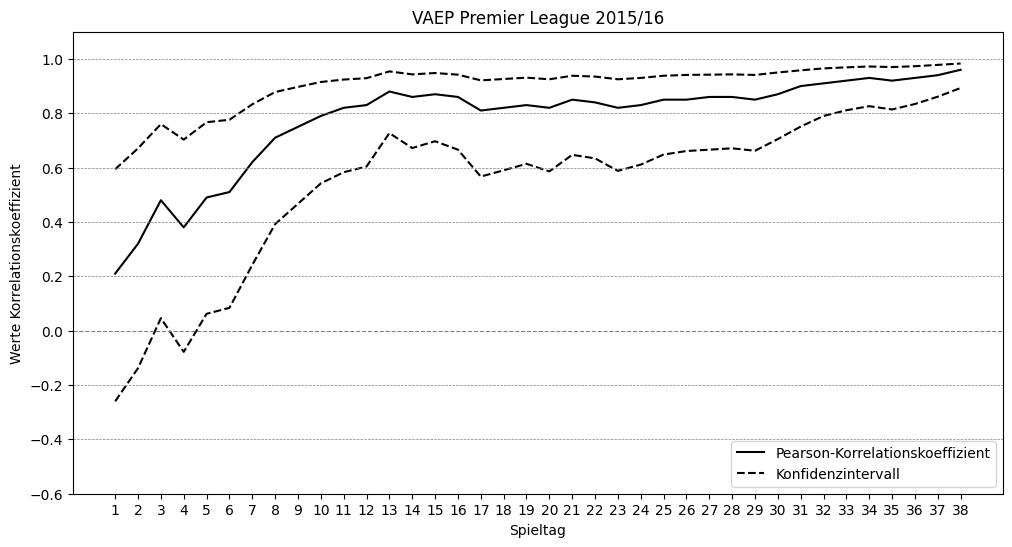

Diagram was saved succesfully /Users/andreas/Desktop/VAEP_Spieltag_Korrelation_Premier League.png


In [11]:
# Standard style (white background)
plt.style.use("default")

# Extract relevant data from DataFrame
spieltag_values = results_pear_df["Spieltag"].astype(int).tolist()
correlation_values = results_pear_df["Pearson Punktekorrelation"].tolist()
confidence_upper_value = results_pear_df["Konfidenzintervall upper Pearson"].tolist()
confidence_lower_value = results_pear_df["Konfidenzintervall lower Pearson"].tolist()

# Create diagram
plt.figure(figsize=(12, 6))
plt.plot(spieltag_values, correlation_values, linestyle='-', label='Pearson-Korrelationskoeffizient', color='black')
plt.plot(spieltag_values, confidence_upper_value, linestyle='dashed', label='Konfidenzintervall', color='black')
plt.plot(spieltag_values, confidence_lower_value, linestyle='dashed', label='', color='black')

# Set title
plt.title(f"VAEP {wettbewerbsname} 2015/16", color='black')

# Set axis titles
plt.xlabel("Spieltag", color='black')
plt.ylabel("Werte Korrelationskoeffizient", color='black')

# Set horizontal lines
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.8, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.6, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.4, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=-0.2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-0.4, color='gray', linestyle='--', linewidth=0.5)

plt.xticks(spieltag_values, rotation=0, color='black')
plt.yticks(color='black')

# Set boundaries
plt.ylim(-0.6, 1.1)

# Set legend
plt.legend(loc='lower right')

# Export diagram
desktop_path = os.path.expanduser("~/Desktop")
diagramm_path = os.path.join(desktop_path, f"VAEP_Spieltag_Korrelation_{wettbewerbsname}.png")
plt.savefig(diagramm_path, dpi=300, bbox_inches='tight', facecolor='white')

# Show diagram
plt.show()

print(f"Diagram was saved succesfully {diagramm_path}")
